In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subset_data = data.sample(n=4000, random_state=42)  # Use a specific random_state for reproducibility

# Display information about the subset



In [ ]:
print(subset_data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2644 to 1469
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4000 non-null   int64 
 1   keyword   3971 non-null   object
 2   location  2648 non-null   object
 3   text      4000 non-null   object
 4   target    4000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.5+ KB
None


In [ ]:
subset_data[data.keyword.notna()].sort_values(by='keyword').head()


<ipython-input-4-c5250725d24c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_data[data.keyword.notna()].sort_values(by='keyword').head()


,id,keyword,location,text,target
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,0
56,80,ablaze,South Africa,TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...,1
58,82,ablaze,hollywoodland,They sky was ablaze tonight in Los Angeles. I'...,0


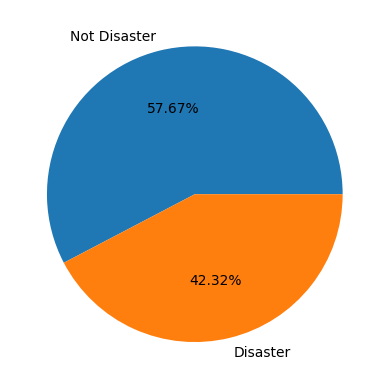

In [ ]:
import matplotlib.pyplot as plt
plt.pie(subset_data.target.value_counts(),
        labels=['Not Disaster','Disaster'],
        autopct='%1.2f%%')
plt.show()

In [ ]:
import re

def clean_text_data(df):
    # Make text lowercase
    df['text'] = df['text'].str.lower()

    # Remove links (URLs)
    df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))

    # Remove emojis (Unicode characters)
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    return df

In [ ]:
data = clean_text_data(subset_data)
test = clean_text_data(test)

In [ ]:
import tensorflow as tf

VOCAB_SIZE = 3000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(subset_data.text.to_list())

vectorized_text = encoder(subset_data.text).numpy()

vectorized_text[:5]

array([[  27,   12,   24,    3,   47,  266,   16,   72,  277,    1,  441,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    1,  575,    8,   62,   10,    1,   30,   96,    1,    4,
           3,  350,  105,   10,    1,    7,    1, 1805,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    1,   94,    1,    2,    1,   65,   72,    1,    3,    1,
           4,    1,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [ 812,   83,    5,  160, 1637,  110,   23,  226,    8,  144,    5,
         455,  229,   10,  554,   14,  426,   64,    3,  226,  308,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   4, 1357,    5,  298,  797,    6,    1,    1,    3,    1,  759,
          58,   16,    1,    1,  126,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score

# Logistic Regression Model
model = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()),
    output_dim=1,
    mask_zero=True),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, None, 1)           3000      
                                                                 
 global_average_pooling1d_1  (None, 1)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 3002 (11.73 KB)
Trainable params: 3002 (11.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def custom_learning_rate(epoch):
    initial_lr = 0.00006
    drop = 0.95
    epochs_drop = 3

    lr = initial_lr * (drop ** (epoch // epochs_drop))

    return lr
lr_scheduler = LearningRateScheduler(custom_learning_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [ ]:
history = model.fit(np.array(data.text),
                    data.target,
                    epochs=25,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

Epoch 1/25
100/100 [==============================] - 1s 5ms/step - loss: 0.6921 - accuracy: 0.5475 - val_loss: 0.6912 - val_accuracy: 0.5788 - lr: 6.0000e-05
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5678 - val_loss: 0.6906 - val_accuracy: 0.5863 - lr: 6.0000e-05
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5738 - val_loss: 0.6899 - val_accuracy: 0.5888 - lr: 6.0000e-05
Epoch 4/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5738 - val_loss: 0.6892 - val_accuracy: 0.5900 - lr: 5.7000e-05
Epoch 5/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5734 - val_loss: 0.6886 - val_accuracy: 0.5913 - lr: 5.7000e-05
Epoch 6/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5738 - val_loss: 0.6879 - val_accuracy: 0.5913 - lr: 5.7000e-05
Epoch 7/25
100/100 [==========================

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import f1_score

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, None, 64)          192000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               197632    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1024)              263168    
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 653825 (2.49 MB)
Trainable params: 65382

In [ ]:
def custom_learning_rate(epoch):
    initial_lr = 0.00006
    drop = 0.95
    epochs_drop = 3

    lr = initial_lr * (drop ** (epoch // epochs_drop))

    return lr
lr_scheduler = LearningRateScheduler(custom_learning_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [ ]:
history = model.fit(np.array(data.text),
                    data.target,
                    epochs=25,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

Epoch 1/25
100/100 [==============================] - 22s 133ms/step - loss: 0.6875 - accuracy: 0.5734 - val_loss: 0.6746 - val_accuracy: 0.5913 - lr: 6.0000e-05
Epoch 2/25
100/100 [==============================] - 8s 82ms/step - loss: 0.6708 - accuracy: 0.5778 - val_loss: 0.6460 - val_accuracy: 0.6612 - lr: 6.0000e-05
Epoch 3/25
100/100 [==============================] - 10s 101ms/step - loss: 0.6112 - accuracy: 0.7009 - val_loss: 0.5507 - val_accuracy: 0.7575 - lr: 6.0000e-05
Epoch 4/25
100/100 [==============================] - 10s 101ms/step - loss: 0.4807 - accuracy: 0.7912 - val_loss: 0.4766 - val_accuracy: 0.7850 - lr: 5.7000e-05
Epoch 5/25
100/100 [==============================] - 10s 101ms/step - loss: 0.4149 - accuracy: 0.8294 - val_loss: 0.4542 - val_accuracy: 0.7937 - lr: 5.7000e-05
Epoch 6/25
100/100 [==============================] - 11s 114ms/step - loss: 0.3646 - accuracy: 0.8550 - val_loss: 0.4602 - val_accuracy: 0.7975 - lr: 5.7000e-05
Epoch 7/25
100/100 [==========

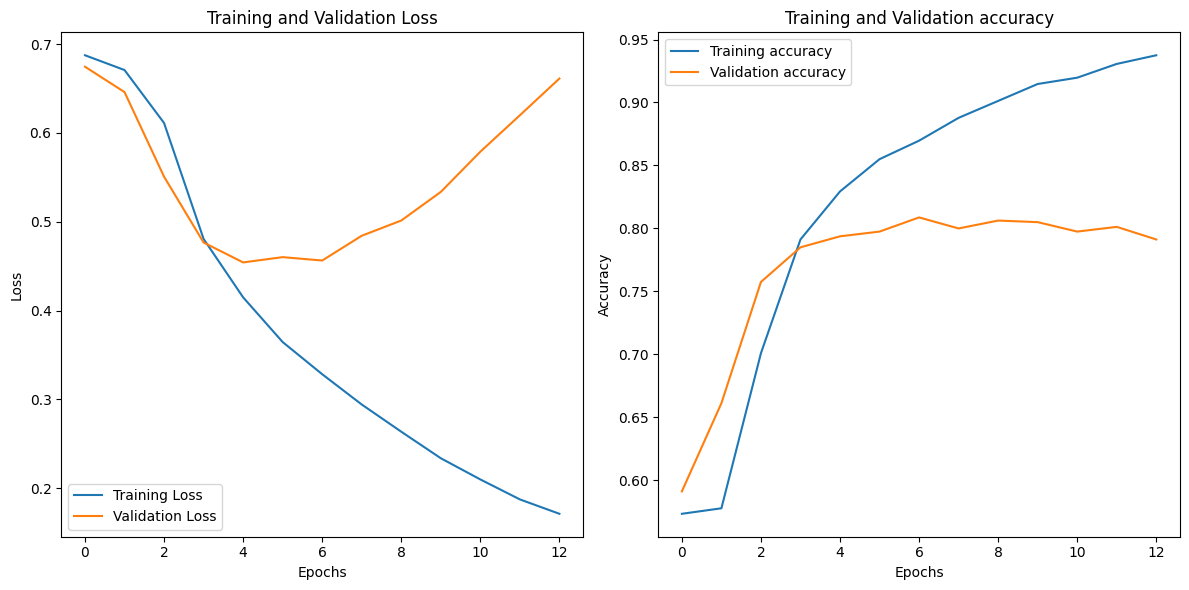

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

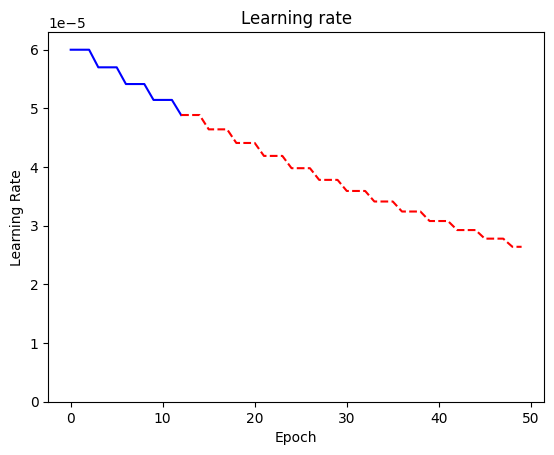

In [ ]:
x = range(50)
n = len(history.history['lr'])
lrs_0 = [custom_learning_rate(i) for i in x[:n]]
lrs_1 = [custom_learning_rate(i) for i in x[n-1:]]
plt.plot(x[:n], lrs_0, color='blue')
plt.plot(x[n-1:], lrs_1, 'r--')
plt.ylim(0, max(history.history['lr'])*1.05)
plt.title('Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

In [ ]:
predictions = model.predict(np.array(test.text.to_list()))
predictions = (predictions > 0.5).astype('int')
submission = pd.DataFrame({'id':test.id.to_list(), 'target':predictions.flatten()})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 5s 23ms/step
